In [1]:
import d2lzh_pytorch as d2l

In [2]:
import torch
import torchvision

In [3]:
import matplotlib

In [4]:
import cvxopt

In [5]:
import cvxpy

In [6]:
import sko
import geatpy
import statsmodels
import pyecharts
import sklearn

In [7]:
from ortools.graph import pywrapgraph
#between each pair. For instance, the arc from node 0 to node 1 has acapacity of 15 and a unit cost of 4.
start_nodes = [ 0, 0,  1, 1,  1,  2, 2,  3, 4]
end_nodes   = [ 1, 2,  2, 3,  4,  3, 4,  4, 2]
capacities  = [15, 8, 20, 4, 10, 15, 4, 20, 5]
unit_costs  = [ 4, 4,  2, 2,  6,  1, 3,  2, 3]
# Define an array of supplies at each node.
supplies = [20, 0, 0, -5, -15]
# Instantiate a SimpleMinCostFlow solver.
min_cost_flow = pywrapgraph.SimpleMinCostFlow()
# Add each arc.
for i in range(0, len(start_nodes)):
    min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[i], end_nodes[i],
                                                capacities[i], unit_costs[i])
# Add node supplies.
for i in range(0, len(supplies)):
    min_cost_flow.SetNodeSupply(i, supplies[i])
 # Find the minimum cost flow between node 0 and node 4.
if min_cost_flow.Solve() == min_cost_flow.OPTIMAL:
    print('Minimum cost:', min_cost_flow.OptimalCost())
    print('')
    print('  Arc    Flow / Capacity  Cost')
    for i in range(min_cost_flow.NumArcs()):
      cost = min_cost_flow.Flow(i) * min_cost_flow.UnitCost(i)
      print('%1s -> %1s   %3s  / %3s       %3s' % (
          min_cost_flow.Tail(i),
          min_cost_flow.Head(i),
          min_cost_flow.Flow(i),
          min_cost_flow.Capacity(i),
          cost))
else:
    print('There was an issue with the min cost flow input.')

Minimum cost: 150

  Arc    Flow / Capacity  Cost
0 -> 1    12  /  15        48
0 -> 2     8  /   8        32
1 -> 2     8  /  20        16
1 -> 3     4  /   4         8
1 -> 4     0  /  10         0
2 -> 3    12  /  15        12
2 -> 4     4  /   4        12
3 -> 4    11  /  20        22
4 -> 2     0  /   5         0


In [1]:
from gurobipy import *
# 8部电影
# 7个影厅
# 8个时段
lt_seat = [118, 86, 116, 85, 156, 142, 156]
# 一行为一个影厅,一列为一部电影
lt_price = [[60, 60, 65, 60, 65, 90, 60, 65],
            [65, 65, 85, 75, 60, 75, 85, 80],
            [60, 70, 75, 80, 75, 80, 80, 75],
            [65, 65, 80, 75, 80, 75, 75, 80],
            [60, 65, 65, 60, 75, 80, 80, 75],
            [60, 65, 65, 80, 75, 75, 80, 75],
            [60, 60, 75, 80, 75, 70, 60, 75]]
# 一行为一个时段,一列为一部电影
lt_rate = [[0.50, 0.55, 0.45, 0.50, 0.60, 0.46, 0.55, 0.45],
           [0.42, 0.43, 0.41, 0.43, 0.45, 0.30, 0.53, 0.36],
           [0.58, 0.63, 0.67, 0.64, 0.70, 0.64, 0.54, 0.57],
           [0.62, 0.67, 0.70, 0.65, 0.75, 0.64, 0.53, 0.66],
           [0.65, 0.65, 0.73, 0.68, 0.75, 0.74, 0.67, 0.72],
           [0.66, 0.69, 0.78, 0.78, 0.78, 0.75, 0.74, 0.70],
           [0.67, 0.92, 0.87, 0.87, 0.75, 0.59, 0.68, 0.68],
           [0.67, 0.92, 0.87, 0.87, 0.75, 0.59, 0.68, 0.68]]
# 计算满座的票房二维列表,lt_all
lt_all = [[0 for col in range(8)] for row in range(7)]
for i in range(7):
    for j in range(8):
        lt_all[i][j] = lt_price[i][j] * lt_seat[i]
# 创建模型
m = Model("arr_mov")
# 创建变量.第i个时段在第j个影厅放映第k部电影
x = m.addVars(8, 7, 8, vtype=GRB.BINARY)
# 更新变量环境
m.update()
# 创建目标函数
m.setObjective(sum(x[i, j, k] * lt_rate[i][k] * lt_all[j][k]
                   for i in range(8) for j in range(7) for k in range(8)),
                   GRB.MAXIMIZE)
# 创建约束条件约束条件
m.addConstrs(sum(x[i,j,k] for i in range(8) for j in range(7)) >= 1 for k in range(8))
m.addConstrs(sum(x.select(i, j, '*')) == 1 for i in range(8) for j in range(7))
# 执行现行规划模型
m.optimize()

# 输出结果
result = [[0 for col in range(7)] for row in range(8)]
solution = m.getAttr('x',x)
# 得到排片矩阵
for k,v in solution.items():
    if v == 1:
        result[k[0]][k[1]] = k[2] + 1
# 得到最大收益值
max_get = sum(solution[i, j, k] * lt_rate[i][k] * lt_all[j][k] for i in range(8) for j in range(7) for k in range(8))
# 打印最大收益值,和排片矩阵
print('最大收益为:',max_get)
print('最佳排片方法:')
for l in result:
    print(l)

Using license file /home/fern/gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-31
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 3 physical cores, 3 logical processors, using up to 3 threads
Optimize a model with 64 rows, 448 columns and 896 nonzeros
Model fingerprint: 0x4eb39152
Variable types: 0 continuous, 448 integer (448 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+03, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 325324.25000
Presolve time: 0.01s
Presolved: 64 rows, 448 columns, 896 nonzeros
Variable types: 0 continuous, 448 integer (448 binary)

Root relaxation: objective 3.865421e+05, 65 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    386542.15000 386542.150  0.0

In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sess = tf.Session() 
a = tf.constant(1) 
b = tf.constant(2) 
print(sess.run(a+b))

Instructions for updating:
non-resource variables are not supported in the long term
3


In [9]:
import tensorflow as tf
print(tf.__version__)
import keras

2.3.0


In [10]:
import cv2

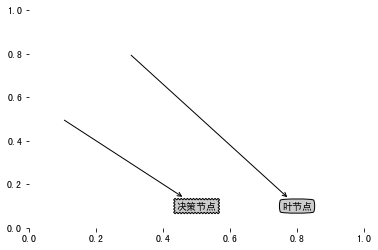

In [11]:
import matplotlib.pyplot as plt
 
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
 
# 定义文本框和箭头格式
decisionNode = dict(boxstyle = "sawtooth", fc = "0.8")
leafNode = dict(boxstyle = "round4", fc = "0.8")
arrow_args = dict(arrowstyle = "<-")
 
# 绘制带箭头的注解
def plotNode(nodeTxt, centerPt, parentPt, nodeType) :
	createPlot.ax1.annotate(nodeTxt, xy = parentPt, xycoords = 'axes fraction', xytext = centerPt, textcoords = 'axes fraction', va = 'center', ha = 'center', bbox = nodeType, arrowprops = arrow_args)
 
def createPlot() :
	fig = plt.figure(1, facecolor='white')
	fig.clf()
	createPlot.ax1 = plt.subplot(111, frameon = False)
	plotNode(U'决策节点', (0.5, 0.1), (0.1, 0.5), decisionNode)
	plotNode(U'叶节点', (0.8, 0.1), (0.3, 0.8), leafNode)
	plt.show()
createPlot()

Matplotlib is building the font cache; this may take a moment.


最大流的流量为： 5
最大流为： {0: {1: 2, 2: 3}, 1: {3: 2}, 2: {1: 0, 4: 3}, 3: {2: 0, 4: 0, 5: 2}, 4: {5: 3}, 5: {}}
最大流的邻接矩阵为：
 [[0 2 3 0 0 0]
 [0 0 0 2 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 2]
 [0 0 0 0 0 3]
 [0 0 0 0 0 0]]


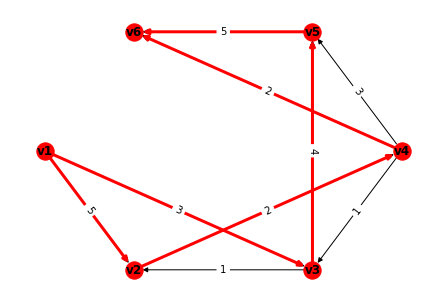

In [2]:
#程序文件Pex10_16.py
import numpy as np
import networkx as nx
import pylab as plt
L=[(1,2,5),(1,3,3),(2,4,2),(3,2,1),(3,5,4),
   (4,3,1),(4,5,3),(4,6,2),(5,6,5)]
G=nx.DiGraph()
for k in range(len(L)):
    G.add_edge(L[k][0]-1,L[k][1]-1, capacity=L[k][2])
value, flow_dict= nx.maximum_flow(G, 0, 5)
print("最大流的流量为：",value)
print("最大流为：", flow_dict)
n = len(flow_dict)
adj_mat = np.zeros((n, n), dtype=int)
for i, adj in flow_dict.items():
    for j, weight in adj.items():
        adj_mat[i,j] = weight
print("最大流的邻接矩阵为：\n",adj_mat)
ni,nj=np.nonzero(adj_mat)  #非零弧的两端点编号
key=range(n)
s=['v'+str(i+1) for i in range(n)]
s=dict(zip(key,s)) #构造用于顶点标注的字符字典
plt.rc('font',size=16)
pos=nx.shell_layout(G)  #设置布局
w=nx.get_edge_attributes(G,'capacity')
nx.draw(G,pos,font_weight='bold',labels=s,node_color='r')
nx.draw_networkx_edge_labels(G,pos,edge_labels=w)
path_edges=list(zip(ni,nj))
nx.draw_networkx_edges(G,pos,edgelist=path_edges,
            edge_color='r',width=3)
plt.show()

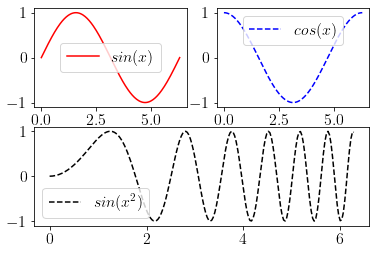

In [4]:
# 例2.39 把屏幕开成3个子窗口，上面两个子窗口，下面一个大的子窗口，3个窗口分别画曲线y=sin(x), y=cos(x), y=sin(x^2), x在[0, 2pi]
import numpy as np
import os
from matplotlib.pyplot import *
x = np.linspace(0, 2 * np.pi, 200)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.sin(x*x)
rc('font', size=16)
rc('text', usetex=True) # 调用tex字库
ax1 = subplot(2, 2, 1) # 新建左上1号子窗口
ax1.plot(x, y1, 'r', label='$sin(x)$') # 画图
legend() # 添加图例
ax2 = subplot(2, 2, 2) # 新建右上2号窗口
ax2.plot(x, y2, 'b--', label='$cos(x)$')
legend()
ax3 = subplot(2, 1, 2) # 新建2行、1列的下面子窗口
ax3.plot(x, y3, 'k--', label='$sin(x^2)$')
legend()
savefig('/home/fern/Downloads/figure2_39.png', dpi=500)
show()